# Machine Learning Using AWS SageMaker

Classification Models using Sleep Data from Kaggle: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset/data.

By Vicente De Leon

## Dependencies

In [2]:
import pandas as pd
import numpy as np
import os
import io
from io import StringIO 
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#pip install boto3

In [ ]:
#pip install -U sagemaker

In [ ]:
#pip install --upgrade s3fs

In [50]:
import sagemaker
import boto3
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
from sagemaker.deserializers import JSONDeserializer

The following S3 Bucket path "s3_path" is where my csv file is currently being stored (copy the S3 URL).

In [4]:
s3_path = "s3://sagemaker-studio-296632356656-77qw9lvy0ee/SleepHealth.csv"
sleep_data = pd.read_csv(s3_path)

In [ ]:
#sleep_data.head()

## Exploratory Data Analysis

Sleep Disorder categories -> None, Sleep Apnea, Insomnia. It seems Jupyter read files in a different way than Google Colab. The two models were created using Colab (to avoid using SageMaker costs etc).

In [5]:
sleep_data["Sleep Disorder"] = sleep_data["Sleep Disorder"].fillna("None")
sleep_data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [6]:
print(sleep_data["Gender"].value_counts())

Gender
Male      189
Female    185
Name: count, dtype: int64


In [7]:
print(sleep_data["Occupation"].value_counts())

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64


I don't really know why the dataset creator has Normal and Normal Weight categories. I will just make them one category instead of having 2.

In [8]:
sleep_data["BMI Category"] = sleep_data["BMI Category"].replace("Normal Weight", "Normal")
print(sleep_data["BMI Category"].value_counts())

BMI Category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64


In [9]:
print(sleep_data["Sleep Disorder"].value_counts())

Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


In [10]:
sleep_data.isnull().sum()

Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

In [11]:
duplicates = sleep_data.duplicated().sum()
print("Number of duplicates in sleep data: ", duplicates)

Number of duplicates in sleep data:  0


In [12]:
sleep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


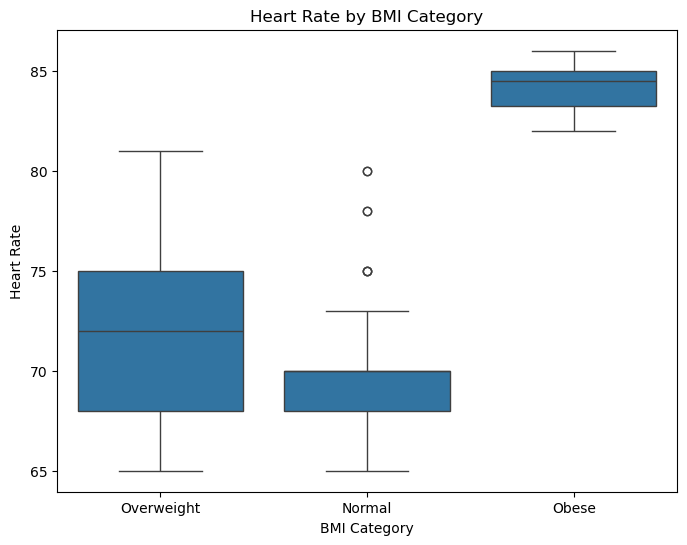

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(data = sleep_data, x = "BMI Category", y = "Heart Rate")
plt.title("Heart Rate by BMI Category")
plt.show()

The above boxplot shows the distributions of heart rates across the three BMI categories as shown below. As we all know the horizontal line within the box shows the median heart rate for each BMI category. There are also some outliers that might indicate that the data points might be usually high or low. The "Normal" category's box is shorter, suggesting less variability in heart rate. The “Obese” category shows that the median heart rate is higher than Normal category, showing more variability among people within this group (wider IQR). The “Overweight” category seemes to indicate a wider IQR, suggesting more variability compares to the "Normal Category".

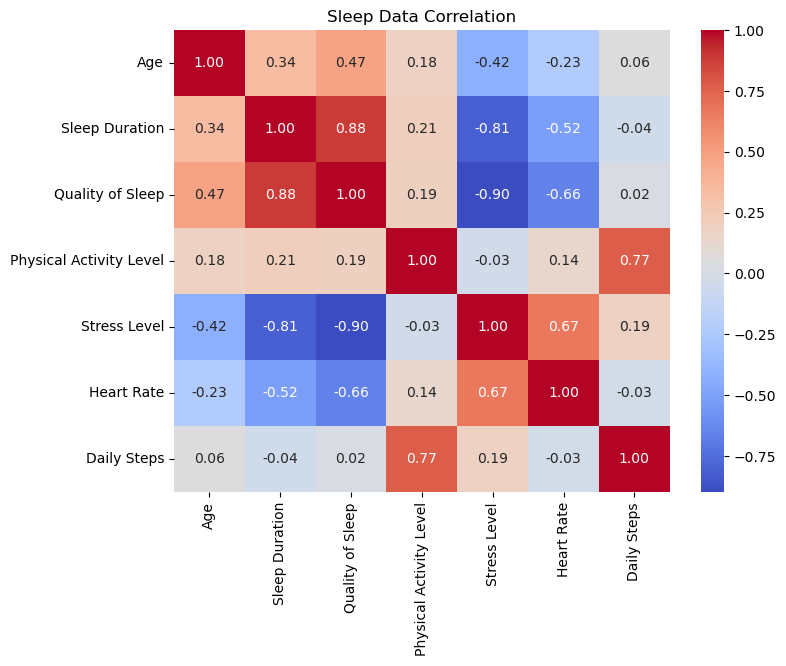

In [14]:
numerical_cols = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"]
plt.figure(figsize=(8, 6))
sns.heatmap(sleep_data[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Sleep Data Correlation")
plt.show()

The above heat map shows the following:
- Strong positive correlation between Quality of Sleep and Sleep Duration (0.88).
- Strong negative correlation between  Stress Level and Sleep Duration (-0.81) and Quality of Sleep (-0.90). Stress Levels may be associated with bad and shorter sleep.
- Strong positive correlation between Daily Steps and Physical Activity Level (0.77). This is something common because more physical activity is generally associated with a higher number of steps taken daily.
- Positive correlation of (0.67) between Stress Level and Heart Rate, indicating that higher stress levels are associated with higher heart rates.

Text(0.5, 1.0, 'Relationship between Sleep Duration and Stress Level by Occupation')

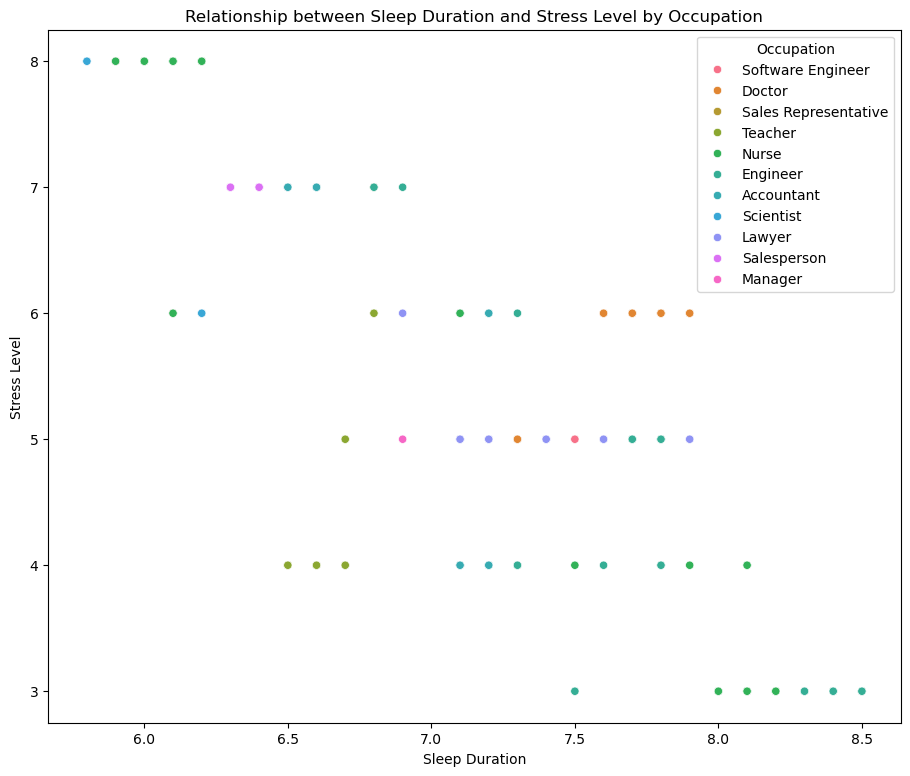

In [15]:
plt.figure(figsize=(11, 9))
sns.scatterplot(data=sleep_data, x = "Sleep Duration", y = "Stress Level", hue = "Occupation")
plt.title("Relationship between Sleep Duration and Stress Level by Occupation")

In [16]:
sleep_data.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


## Model Implementation

The data shows it is a mix of numerical and categorical variables. It is a clean dataset with no null values and no duplicates. Since I was getting really used to work with TensorFlow (Keras), for this project I will be working with Scikit-Learn and apply everything I learnt from the Applied Machine Learning course from Professor James Shanahan. 

I am going to be implementing many steps from the Sklearn library such as preprocessing steps, pipelines, transformers, feature engineering etc. Also, I tried to understand how to read blood pressure numbers and I came across an article that explains how to read those numbers. It seems the number on the top is the “systolic blood pressure” and the second number that goes under systolic is the “diastolic blood pressure”.

Systolic blood pressure (the first number) – indicates how much pressure your blood is exerting against your artery walls when the heart contracts. This tend to be the most “important” number due to being a major risk factor for cardiovascular disease for people over 50.
Diastolic blood pressure (the second number) – indicates how much pressure your blood is exerting against your artery walls while the heart muscle is resting between contractions. So, knowing this I will try and split these two numbers into two new columns to see if I can get a much better performance off these models.


All techniques and structures were taken from my notes and homeworks from -> Applied Machine Learning course by Professor James Shannahan. Additionally, lets train_test_split the data using the same default configuration I've used during the applied machine learning course.

## Model 1: Logistic Regression
This is a logistic regression model created to predict the likelyhood of someone having a Sleep Disorder (None, Insomnia, Sleep Apnea). This can be considered a multiclassification task.

In [17]:
X = sleep_data.drop(["Sleep Disorder"], axis=1)  # Feature variables, also dropping target variable
y = sleep_data["Sleep Disorder"]  # Target variable

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # validation sets

In [19]:
X_train.shape

(239, 12)

In [20]:
y_test.shape

(75,)

### Preprocessing and Feature Engineering

In [21]:
num_cols = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"] # numerical columns
cat_cols = ["Gender", "Occupation", "BMI Category"] # categorical columns

The following "split_bp()" function was created with the intent of being used within the ColumnTransformer in the pipelines below to ensure the "Blood Pressure" data splitting. 

Blood Pressure -> Systolic_Bp and Diastolic_Bp

However, due to how SageMaker processes data during deployment made this extremely dificult. I had no problem locally testing this scenario (I was getting the correct predictions), even creating a testing simulation worked giving all desire results. In the case of deployment endpoint, everything changes and I had to made some changes to avoid running into errors. I decided to keep the split_bp() function because it gives better results, it just part of preprocessing. Instead of being applied directly within the pipeline, the function will be applied to the X_train and X_test sets before training and testing.

In [22]:
def split_bp(df):
    bp_column = df["Blood Pressure"].str.split("/", n = 1, expand = True) # splitting blood pressure
    df["Systolic_BP"] = pd.to_numeric(bp_column[0]) # containing systolic values
    df["Diastolic_BP"] = pd.to_numeric(bp_column[1]) # containing diastolic values
    return df.drop("Blood Pressure", axis = 1)  # dropping original "Blood Pressure" column

In [23]:
#bp_transformer = FunctionTransformer(split_bp)

We are dealing with a mix of categorical and numerical data. I am going to be using one-hot encoding for the following columns: “Gender”, “Occupation”, and “BMI Category”. Also, I am going to be applying label encoding to the following column “Sleep Disorder” because it has levels of None, Insomnia, and Sleep Apnea. Regarding the numerical data, I will be implementing some standardization as part of the feature engineering. At the end, I will combine these scaled and encoded features into a dataframe.

Since I will me implementing regression models, I will be using standardization instead of normalization. Standardization centers data around a mean of zero and a standard deviation of one.

The Numerical and Categorical Preprocessing Pipelines:

In [24]:
# Preprocessing pipeline for numerical data
num_pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy = "mean")),  # imputing missing values if any
                ("scaler", StandardScaler())  # scaling numerical values
])

# Preprocessing pipeline for categorical data
cat_pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy = "most_frequent")),  # imputting missing values if any
                ("onehot", OneHotEncoder(handle_unknown = "ignore"))  # one-hot encoding categorical values
])

Using custome function, Transformer, and Full Pipeline:

In [ ]:
# Creating the preprocessor and applying bp_trasformer
#preprocessor = ColumnTransformer(transformers=[
                #("num_pipeline", num_pipeline, num_cols), # numerical
                #("cat_pipeline", cat_pipeline, cat_cols), # categorical
                #("bp_transformer", bp_transformer, ["Blood Pressure"])  # applying bp_transformer
    #])

In [25]:
# No bp_transformer (split_bp()) wihtin the following preprocessor:
preprocessor = ColumnTransformer(transformers=[
                ("num_pipeline", num_pipeline, num_cols), # numerical
                ("cat_pipeline", cat_pipeline, cat_cols) # categorical
    ])

# Creating the full pipeline using the above preprocessor and the Logistic regression model
logistic_pipe = Pipeline([
            ("preprocessor", preprocessor), # preprocessor
            ("lr", LogisticRegression())  # logistic regression for model 1
])

In [26]:
logistic_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sleep Duration',
                                                   'Quality of Sleep',
                                                   'Physical Activity Level',
                                                   'Stress Level', 'Heart Rate',
                                                   'Daily Steps']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Occupation',
                                                   'BMI Category'])])),
                ('lr', LogisticRegression())])

### Hyperparamater Tuning 

GridSearchCV - hyperparameter tuning

In [27]:
params = {
    "lr__C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],  # regularization strength used in applied machine learning
    "lr__penalty": ["none", "l1", "l2", "elasticnet"],  # regularization - penalities applied machine learning
    "lr__solver": ["newton-cg", "lbfgs", "sag", "saga"],  # solvers appliead machine learning
}

# GridSearchCV
grid_search = GridSearchCV(logistic_pipe, param_grid = params, cv = 5, scoring = "accuracy", n_jobs = -1, verbose = 2)

### Training

In [28]:
X_train_splitbp = split_bp(X_train) # this is were split_bp() is getting applied

In [ ]:
grid_search.fit(X_train_splitbp, y_train)

In [30]:
# Best hyperparameters from my gridsearchcv
print("Best hyperparameters from GridSearchCV:", grid_search.best_params_)

Best hyperparameters from GridSearchCV: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}


In [31]:
estimator = grid_search.best_estimator_ # using this best estimator to train and save model

In [33]:
# Getting the Training accuracy
y_train_pred = estimator.predict(X_train_splitbp)
logistic_train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy for Logistic Regression:", logistic_train_accuracy)

Training Accuracy for Logistic Regression: 0.9037656903765691


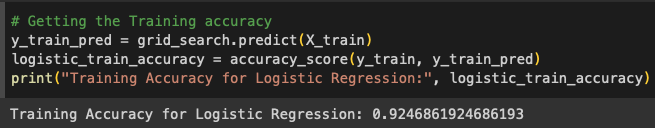

The above image shows a training accuracy of 0.92. This accuracy comes from training the logistic regression model using the split_bp() function in the ColumnTransformer within the preprocessing pipelines. In my case, since I took this preprocessing step out of the pipelines, my accuracy is 0.90. This is something I would normally look into, however since I don't really know about AWS SageMaker, I preffer to play it safe and just move towards deployment. The same will go into the Validation and Testing Accuracies.

### Validation

In [34]:
X_valid_splitbp = split_bp(X_valid)

In [35]:
# Evaluating the Validation Accuracy
y_valid_pred = estimator.predict(X_valid_splitbp)
logistic_valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy for Logistic Regression:", logistic_valid_accuracy)

Validation Accuracy for Logistic Regression: 0.85


### Training vs Validation Accuracy

The following graph will help me determine if my model might be underfitting or overfitting. The graph will compare the model's training and validation accuracies. If the training accuracy is significantly higher than the validation accuracy, it might indicate overfitting. On the other hand, if both accuracies are comparably high, it suggests that the model generalizes well. If both are low, the model might be underfitting.

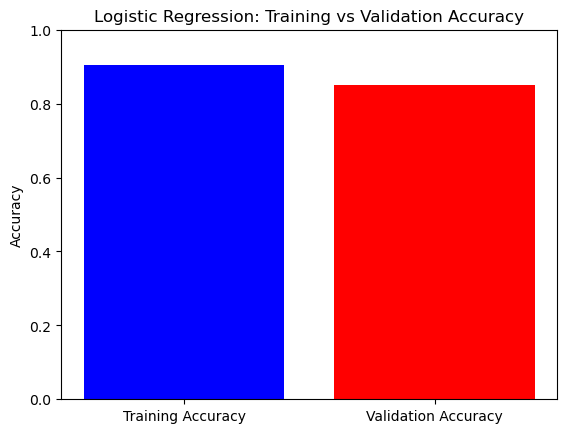

In [36]:
acc_labels = ["Training Accuracy", "Validation Accuracy"]
acc_values = [logistic_train_accuracy, logistic_valid_accuracy]

plt.bar(acc_labels, acc_values, color=["blue", "red"])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Logistic Regression: Training vs Validation Accuracy")
plt.show()

I can say it is generalizing well.

### Saving the Trained Portion of Model 1

I am going to be saving the model artifacts (trained model parameters).

In [37]:
# Save the best estimator from the GridSearchCV
joblib.dump(grid_search.best_estimator_, "model1.joblib") # I will see this within jupyter lab

['model1.joblib']

**AWS documentation states that SageMaker requires models to be stored as a compressed TAR File (tar.gz):**

In [38]:
# with tarfile.open(output_filename, "w:gz") as tar:
        #tar.add(source_dir, arcname=os.path.basename(source_dir))

with tarfile.open("model1.tar.gz", "w:gz") as tar:
    tar.add("model1.joblib", arcname=os.path.basename("model1.joblib")) # S3 Bucket needs tar.gz

**Uploading local file or directory to S3 Bucket**

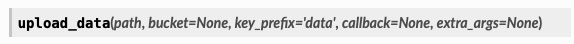

In [39]:
session = sagemaker.Session() # session

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [40]:
s3_bucket = "sagemaker-studio-296632356656-77qw9lvy0ee" # my s3 bucket created within console
model1_prefix = "model1/logistic-regression" # model 1 is the folder that will be displayed on console
model1_path = "model1.tar.gz" # path where the local model is saved 

# Uploading the model to S3 Bucket
model1_upload_s3 = session.upload_data(path = model1_path, bucket = s3_bucket, key_prefix = model1_prefix)
print("Model uploaded to:", model1_upload_s3)

Model uploaded to: s3://sagemaker-studio-296632356656-77qw9lvy0ee/model1/logistic-regression/model1.tar.gz


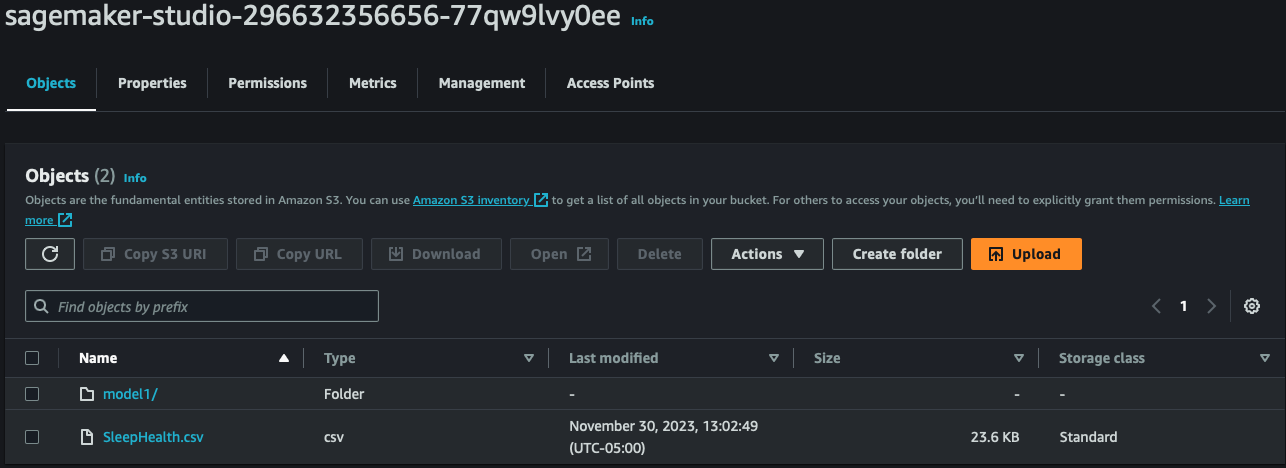

**Creating SageMaker Model**

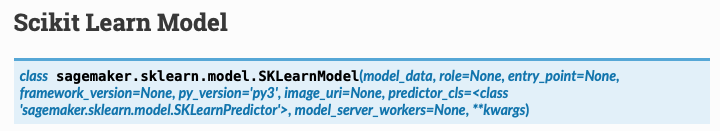

In [41]:
role = sagemaker.get_execution_role() # role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


**Inference**

The below code is the inference.py which is needed for the inference predictions.
- model_fn: loads the model 
- input_fn: process input
- predict_fn: making predictions
- output_fn: process the output

In [42]:
# Creating SKlearn Model SageMaker Version
aws_model = SKLearnModel(model_data = model1_upload_s3, # path to model 1 file
                         role = role, # this is the SageMaker execution role
                         entry_point = "inference.py", # for model predictions ( this is extremely important)
                         framework_version = "1.0-1") # getting errors: sklearn compatible version -> 0.20.0, 0.23-1, 1.0-1, 1.2-1.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Local Testing

In [43]:
model1 = joblib.load("model1.joblib")

In [44]:
data = split_bp(X_test) # applying the split_bp() function directly to X_test

In [45]:
sample = data.iloc[0:10]

In [46]:
predictions = model1.predict(sample)
print(predictions)

['None' 'None' 'None' 'None' 'None' 'Insomnia' 'None' 'None' 'None' 'None']


### Deployment

In [47]:
aws_predictor = aws_model.deploy(instance_type = "ml.m5.large",  # reference instance from hugging face, but large not xl
                                     initial_instance_count=1)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
-----!

In [48]:
aws_predictor.endpoint_name # getting enpoint name

'sagemaker-scikit-learn-2023-12-02-00-25-28-501'

**Checking if the endpoint is working**

In [49]:
client = sagemaker.Session().sagemaker_client

# Describe the endpoint
response = client.describe_endpoint(EndpointName="sagemaker-scikit-learn-2023-12-02-00-25-28-501")

print("Endpoint Status: " + response["EndpointStatus"])

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Endpoint Status: InService


### Testing The Endpoint

In [51]:
testing_data = split_bp(X_test) # lets apply the split_bp() function to the X_test set

In [52]:
testing_sample = data.iloc[0:10] # lets pick 10

Content type options for Amazon SageMaker algorithm inference requests include: text/csv, application/json, and application/x-recordio-protobuf. In the case of SageMaker (SageMaker's endpoint for model predictions) we often need to send and recieve data as strings in CSV or JSON formats.

Source: https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-data-format-tabular-response.html

In [53]:
# Convert X_test to a csv string
csv_buffer = StringIO()
testing_sample.to_csv(csv_buffer, header=True, index=False) # to csv format
csv_string = csv_buffer.getvalue()

First, we need to specify how the input data should be serialized before sending it to the endpoint. Then the prediction should be deserialized once it's received back from the endpoint.

- serializer=CSVSerializer() -> Serialize data of various formats to a CSV-formatted string. This is the required format for the model endpoint to correctly process the data. I am ensuring that the input data is in csv format.

- deserializer=JSONDeserializer() -> Deserializer data to a JSON formatted string. Predictions is expected to be in JSON format. Basically, it converts the JSON formatted prediction response from the endpoint into a Python object.

In [54]:
endpoint_name = "sagemaker-scikit-learn-2023-12-02-00-25-28-501"  # endpoint name
aws_predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer(), deserializer=JSONDeserializer())

prediction = aws_predictor.predict(csv_string)
print(prediction)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
['None', 'None', 'None', 'None', 'None', 'Insomnia', 'None', 'None', 'None', 'None']


The above predictions show that the deployed endpoint worked.

**How testing went in Colab (normal ml workflow):**

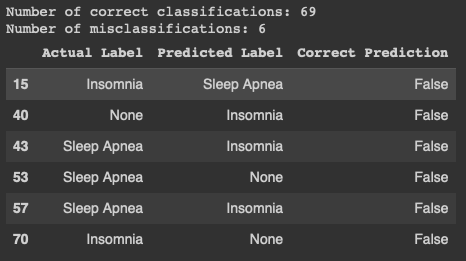

**Deleting the Endpoint to avoid Costs:**

In [96]:
#session = sagemaker.Session()
session.delete_endpoint("sagemaker-scikit-learn-2023-12-02-00-25-28-501")

## Model 2: Choosing the Best Model

This is a multiclassficiation task to predict stress levels based on various factors such as Sleep Quality, Physical Activity, Daily Steps, and others. Stress Levels from 3 to 8 (3, 4, 5, 6, 7, 8).

In [55]:
X = sleep_data.drop(["Stress Level"], axis=1)  # dropping the target variable
y = sleep_data["Stress Level"]  # target variable

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [57]:
X_train.shape

(239, 12)

In [58]:
y_test.shape

(75,)

### Preprocessing and Feature Engineering

In [60]:
num_cols = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Heart Rate", "Daily Steps"] # numerical
cat_cols = ["Gender", "Occupation", "BMI Category"]  # catgeorical

In [61]:
num_pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy = "mean")),  # imputing missing values if any
                ("scaler", StandardScaler())  # scaling numerical values
])

# Preprocessing pipeline for categorical data
cat_pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy = "most_frequent")),  # imputting missing values if any
                ("onehot", OneHotEncoder(handle_unknown = "ignore"))  # one-hot encoding categorical values
])

In [62]:
preprocessor = ColumnTransformer(transformers=[
                ("num_pipeline", num_pipeline, num_cols), # numerical
                ("cat_pipeline", cat_pipeline, cat_cols) # categorical
    ])

# Creating the full pipeline using the above preprocessor and the Logistic regression model
full_pipe = Pipeline([
            ("preprocessor", preprocessor), # preprocessor
            ("classifier", None)  # None
])

In [63]:
full_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sleep Duration',
                                                   'Quality of Sleep',
                                                   'Physical Activity Level',
                                                   'Heart Rate',
                                                   'Daily Steps']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Occupation',
                                                   'BMI Category'])])),
                ('classifier', None)])

### Hyperparamater Tuning

In [64]:
params = [
    {
        "classifier": [DecisionTreeClassifier()],
        "classifier__max_depth": [3, 5, 7],
        "classifier__min_samples_split": [10, 20],
        "classifier__min_samples_leaf": [10, 20],
    },
    {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [100, 150],
        "classifier__max_features": ["auto"],
        "classifier__max_depth": [3, 5, 7],
        "classifier__min_samples_split": [10, 20],
        "classifier__min_samples_leaf": [10, 20],
    },
    {
        "classifier": [SVC()],
        "classifier__C": [1, 10],
        "classifier__kernel": ["rbf"],
        "classifier__gamma": ["scale"]
    }
]


# GridSearchCV
grid_search = GridSearchCV(full_pipe, param_grid = params, cv = 5, scoring = "accuracy", n_jobs = -1, verbose = 2)

### Training

In [65]:
X_train_splitbp = split_bp(X_train) # this is were split_bp() is getting applied

In [ ]:
grid_search.fit(X_train_splitbp, y_train)

In [67]:
# Best hyperparameters from my gridsearchcv
print("Best hyperparameters from GridSearchCV:", grid_search.best_params_)

Best hyperparameters from GridSearchCV: {'classifier': SVC(), 'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


In [68]:
estimator = grid_search.best_estimator_ # using this best estimator to train and save model

In [70]:
# Getting the Training accuracy
y_train_pred = estimator.predict(X_train_splitbp)
model_train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy for Best Model:", model_train_accuracy)

Training Accuracy for Best Model: 1.0


I know that the accuracy score for the above training is something that I should really look into. This didn't happened in Colab (I actually got 0.94 because of the split_bp() within the preprocessing pipeline). Since the main focus here is actually deploying the endpoint without any errors, I will let this slide for now. For future scenarios, this can't happen.

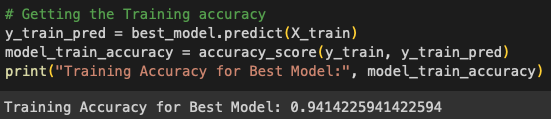

### Validation

In [71]:
X_valid_splitbp = split_bp(X_valid)

In [73]:
# Evaluating the Validation Accuracy
y_valid_pred = estimator.predict(X_valid_splitbp)
model_valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy for Best Model:", model_valid_accuracy)

Validation Accuracy for Best Model: 0.95


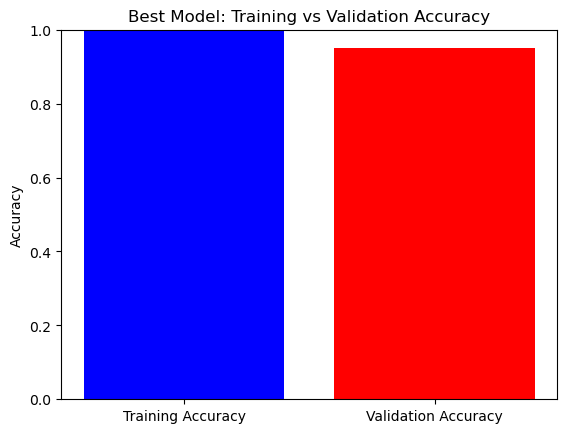

In [75]:
acc_labels = ["Training Accuracy", "Validation Accuracy"]
acc_values = [model_train_accuracy, model_valid_accuracy]

plt.bar(acc_labels, acc_values, color=["blue", "red"])
plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.title("Best Model: Training vs Validation Accuracy")
plt.show()

### Saving the Trained Portion of Model 2

In [76]:
# Save the best estimator from the GridSearchCV
joblib.dump(grid_search.best_estimator_, "model2.joblib") # I will see this within jupyter lab

['model2.joblib']

**AWS documentation states that SageMaker requires models to be stored as a compressed TAR File (tar.gz):**

In [77]:
with tarfile.open("model2.tar.gz", "w:gz") as tar:
    tar.add("model2.joblib", arcname=os.path.basename("model2.joblib")) # S3 Bucket needs tar.gz

**Uploading local file or directory to S3 Bucket**

In [78]:
session = sagemaker.Session() # session

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [79]:
s3_bucket = "sagemaker-studio-296632356656-77qw9lvy0ee" # my s3 bucket created within console
model2_prefix = "model2/classification-models" # model 1 is the folder that will be displayed on console
model2_path = "model2.tar.gz" # path where the local model is saved 

# Uploading the model to S3 Bucket
model2_upload_s3 = session.upload_data(path = model2_path, bucket = s3_bucket, key_prefix = model2_prefix)
print("Model uploaded to:", model2_upload_s3)

Model uploaded to: s3://sagemaker-studio-296632356656-77qw9lvy0ee/model2/classification-models/model2.tar.gz


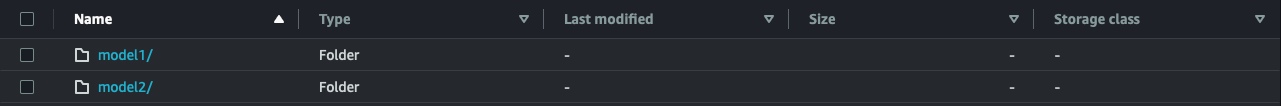

**Creating SageMaker Model**

In [80]:
role = sagemaker.get_execution_role() # role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [87]:
aws_model2 = SKLearnModel(model_data = model2_upload_s3, # path to model 1 file
                         role = role, # this is the SageMaker execution role
                         entry_point = "inference2.py", # have to change model1 to model2
                         framework_version = "1.0-1") # getting errors: sklearn compatible version -> 0.20.0, 0.23-1, 1.0-1, 1.2-1.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Local Testing

In [82]:
model2 = joblib.load("model2.joblib")

In [83]:
data = split_bp(X_test) # applying the split_bp() function directly to X_test

In [84]:
sample = data.iloc[0:10]

In [85]:
predictions = model2.predict(sample)
print(predictions)

[3 8 8 3 8 7 8 4 3 5]


Local testing works (we can see the above stress levels), let's see if we don't run into trouble during deployment.

### Deployment

In [88]:
aws_predictor2 = aws_model2.deploy(instance_type = "ml.m5.large",  # reference instance from hugging face, but large not xl
                                     initial_instance_count=1)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
-----!

In [89]:
aws_predictor2.endpoint_name # getting enpoint name

'sagemaker-scikit-learn-2023-12-02-01-48-00-065'

**Checking if the endpoint is working**

In [90]:
client = sagemaker.Session().sagemaker_client

# Describe the endpoint
response = client.describe_endpoint(EndpointName="sagemaker-scikit-learn-2023-12-02-01-48-00-065")

print("Endpoint Status: " + response["EndpointStatus"])

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Endpoint Status: InService


### Testing the Endpoint

In [91]:
testing_data = split_bp(X_test) # lets apply the split_bp() function to the X_test set

In [92]:
testing_sample = data.iloc[0:10] # lets pick 10

In [93]:
# Convert X_test to a csv string
csv_buffer = StringIO()
testing_sample.to_csv(csv_buffer, header=True, index=False) # to csv format
csv_string = csv_buffer.getvalue()

In [94]:
endpoint_name = "sagemaker-scikit-learn-2023-12-02-01-48-00-065"  # endpoint name
aws_predictor2 = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer(), deserializer=JSONDeserializer())

prediction2 = aws_predictor2.predict(csv_string)
print(prediction2)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
[3, 8, 8, 3, 8, 7, 8, 4, 3, 5]


The above predictions indicate that the deployed endpoint also worked.

**Normal ML testing in Colab:**

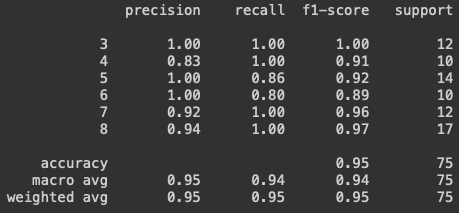

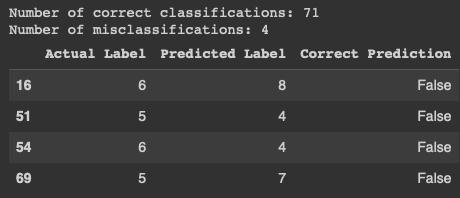

**Deleting the Endpoint to avoid Costs:**

In [95]:
#session = sagemaker.Session()
session.delete_endpoint("sagemaker-scikit-learn-2023-12-02-01-48-00-065")

## My Endpoints in AWS SageMaker Console

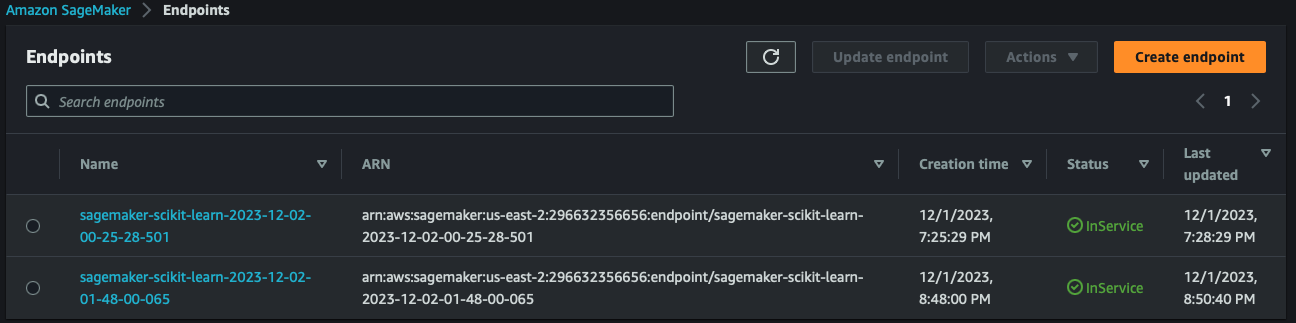

## All References:

- Pandas value_counts: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html
- replace method: https://www.w3schools.com/python/ref_string_replace.asp
- isnull: https://www.geeksforgeeks.org/python-pandas-isnull-and-notnull/
- Split function: https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/
- BoxPlots: https://www.simplypsychology.org/boxplots.html
- HeatMap: https://indianaiproduction.com/seaborn-heatmap/
- HeatMap; https://seaborn.pydata.org/generated/seaborn.heatmap.html
- Scatter plots: https://seaborn.pydata.org/generated/seaborn.scatterplot.html
- Understanding Blood Pressure numbers: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
- Split function: https://www.w3resource.com/pandas/series/series-str-split.php
- Function Transformer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html
- Function transformer: https://stackoverflow.com/questions/38466432/what-is-scikit-learn-functiontransformer-used-for
- Feature Scaling: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
- Function Transformer and Pipeline creation: https://towardsdatascience.com/using-functiontransformer-and-pipeline-in-sklearn-to-predict-chardonnay-ratings-9b13fdd6c6fd
- Sklearn pipelines: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- Sklearn pipelines: https://scikit-learn.org/stable/modules/compose.html
- ColumnTransformers: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
- Sklearn logistic regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- GridSearchCV: https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee
- SKleanr Solvers: https://medium.com/@arnavr/scikit-learn-solvers-explained-780a17bc322d
- Validation losses from GridSearchCV: https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv
- Confusion matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
- using best params: https://thinkingneuron.com/how-to-find-best-hyperparameters-using-gridsearchcv-in-python/
- predicting using best estimator from GridSearchCV: https://stackoverflow.com/questions/35388647/how-to-use-gridsearchcv-output-for-a-scikit-prediction
- Resseting: https://www.w3schools.com/python/pandas/ref_df_reset_index.asp
- Lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
- Ridge: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
- ElasticNet: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
- AWS Notebook Instance: https://sagemaker-workshop.com/introduction/notebook.html
- Saving Model: https://www.analyticsvidhya.com/blog/2023/02/how-to-save-and-load-machine-learning-models-in-python-using-joblib-library/
- tarfile: https://docs.python.org/3/library/tarfile.html
- path base name: https://www.geeksforgeeks.org/python-os-path-basename-method/
- example 4 tar file basename: https://www.programcreek.com/python/?CodeExample=create+tarfile
- Train, compli,e and package models: https://docs.aws.amazon.com/sagemaker/latest/dg/edge-getting-started-step2.html
- upload_data: https://sagemaker.readthedocs.io/en/stable/session.html
- Scikit Learn Model Parameters: https://sagemaker.readthedocs.io/en/stable/sagemaker.sklearn.html
- Training ML model using Scikit Learn and SageMaker (Extremely Useful): https://medium.com/@joanisaac.biel/3-steps-to-train-a-ml-model-using-scikit-learn-and-aws-sagemaker-46aa1b7551f6
- Converting data for inference: https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html
- inference.py: https://course19.fast.ai/deployment_amzn_sagemaker.html
- deploy():https://sagemaker.readthedocs.io/en/stable/api/inference/model.html
- hugginface: https://huggingface.co/docs/sagemaker/inference
- Deploy on SageMaker (Extremely useful for predictor): https://course19.fast.ai/deployment_amzn_sagemaker.html
- Predictors: https://sagemaker.readthedocs.io/en/stable/predictors.html
- SageMaker model: https://sagemaker.readthedocs.io/en/v1.3.0/model.html
- describe_endpoint: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_endpoint.html
- Endpoint response CSV and JSON: https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-data-format-tabular-response.html
- csv buffer: https://pythontic.com/pandas/serialization/to_csv
- serializer: https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html
- desirilizer: https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html
- Deployment: https://towardsdatascience.com/deploying-a-pre-trained-sklearn-model-on-amazon-sagemaker-826a2b5ac0b6
- Deployment: https://ram-vegiraju.medium.com/training-and-deploying-custom-scikit-learn-models-on-aws-sagemaker-3de6a2f669f4
- Some Endpoint and Deployment info: https://stackoverflow.com/questions/72058686/how-do-i-deploy-a-pre-trained-sklearn-model-on-aws-sagemaker-endpoint-stuck-on
- Sickit Learn SageMaker Documentation: https://sagemaker.readthedocs.io/en/stable/sagemaker.sklearn.html
- Using my own inference container: https://docs.aws.amazon.com/sagemaker/latest/dg/adapt-inference-container.html